<a href="https://colab.research.google.com/github/NikkiShah93/Python/blob/main/MLProjects/PyTorchProjects/DeepLearning/CNN_PyTorch_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN with Color samples

We will be using the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

The steps in this project are as follows:
- [Loading](#loading)
- [Exploring](#explore)

- Modelling
  - [Building](#buildm)
  - [Training](#trainm)
  - [Evaluating](#evalm)

In [ ]:
## first the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pathlib import Path

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
## making our project device agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
## defining other static values
RANDOM_SEED = 60
DATA_PATH = '../data/'
PATH = Path(DATA_PATH)
PATH.mkdir(parents =True, exist_ok=True)
np.random.seed(RANDOM_SEED)

<a name='loading'></a>
### Loading the Data

In [ ]:
## we need to get the CIFAR100 dataset from torchvision
transform_inc = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([.5,.5,.5], [.5, .5, .5])])
train_data = datasets.CIFAR100(root = DATA_PATH,
                              transform=transform_inc,
                              train=True,
                              download=True)
test_data = datasets.CIFAR100(root=DATA_PATH,
                             transform=transform_inc,
                             train=False)
classes = train_data.classes
## we need to then convert these to dataloader
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(test_data,
                                           batch_size=BATCH_SIZE,
                                           drop_last=True)
## getting the first batch of data
batch_feat, batch_lab = next(iter(train_loader))
color_channel = batch_feat.shape[1]
input_shape = batch_feat.shape[2]
batch_feat.shape, batch_lab.shape

100%|██████████| 169001437/169001437 [00:04<00:00, 41589409.24it/s]


Extracting ../data/cifar-100-python.tar.gz to ../data/


(torch.Size([128, 3, 32, 32]), torch.Size([128]))

<a name='explore'></a>
### Exploring the Data

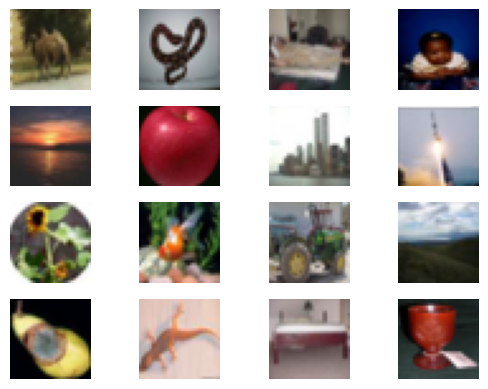

In [ ]:
## showing the first few samples
nrows, ncols = 4, 4
c = 1
for i in range(16):
  ## de-normalizing the data
  image = batch_feat[i] / 2 + .5
  plt.subplot(nrows, ncols, c)
  plt.imshow(torch.permute(image, (1,2,0)))
  plt.axis(False);
  c+=1

<a name='buildm'></a>
### Building the Model

In [ ]:
## we need to create a class
## that inherits from the nn.Module
class CNNClass(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape, in_channels):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=input_shape,
                  kernel_size=(2,2),
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units * 2,
                  kernel_size=(2,2),
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2)))
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units* 2,
                  out_channels=hidden_units* 2,
                  kernel_size=(2,2),
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units* 2,
                  out_channels=hidden_units,
                  kernel_size=(2,2),
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(2,2),
                  padding=1),
        nn.Dropout(.3),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=(2,2),
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2))
    )
    self.output = nn.Sequential(
        nn.Flatten(1),
        nn.Linear(hidden_units * 5 * 5, output_shape)
    )

  ## defining the forward path
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    out = self.conv1(x)
    # print(out.shape)
    out = self.conv2(out)
    # print(out.shape)
    out = self.conv3(out)
    # print(out.shape)
    return self.output(out)

## creating an instance
n_classes = len(classes)
cnn_model = CNNClass(input_shape=input_shape,
                     in_channels=color_channel,
                     hidden_units=128,
                     output_shape=n_classes).to(device)
## defining the loss and optimizer
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = cnn_model.parameters(),
                             lr = learning_rate, weight_decay=1e-6)

<a name='trainm'></a>
### Training the Model

In [ ]:
epochs = 18
loss_dict = {}
running_loss = 0
correct_labels = 0
for e in range(epochs):
  for b, data in enumerate(train_loader, 0):
    image, label = data
    ## moving the data into selected device
    image, label = image.to(device), label.to(device)
    ## predicting the labels
    predictions = cnn_model(image)
    ## calculating the loss
    loss = loss_fn(predictions, label)
    ## zeroing the grad
    optimizer.zero_grad()
    ## backpropagation
    loss.backward()
    ## taking a step
    optimizer.step()
    running_loss += loss.item()
    correct_labels += (predictions.argmax(1) == label).sum() / len(label)
    if b % 10:
      loss_dict[b + (BATCH_SIZE*(e+1))] = loss.item()
  print(f'Epoch:{e} | Average Loss: {running_loss/BATCH_SIZE:.4f} | Average Accuracy: {(correct_labels/len(train_loader))*100:.2f}%')
  running_loss = 0
  correct_labels = 0

Epoch:0 | Average Loss: 11.5280 | Average Accuracy: 12.64%
Epoch:1 | Average Loss: 8.8722 | Average Accuracy: 28.62%
Epoch:2 | Average Loss: 7.4733 | Average Accuracy: 38.02%


In [ ]:
plt.plot(*zip(*loss_dict.items()), label='loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss');

<a name='evaluate'></a>
### Evaluation

In [ ]:
## we need to write our testing loop
cnn_model.eval()
running_loss = 0
running_accuracy = 0
with torch.inference_mode():
  for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    preds = cnn_model(image)
    loss = loss_fn(preds, label)
    running_loss += loss.item()
    running_accuracy += (preds.argmax(1) == label).sum() / BATCH_SIZE
  print(f'Evaluation results => Average Loss : {running_loss/len(test_loader):.4f} | Average Accuracy: {(running_accuracy/len(test_loader))*100:.2f}%')